In [323]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [324]:
import xgcm
    
def filter_iteration(u, mask=None, x='xq', y='yh', niter=1, filter_width=np.sqrt(6)):
    weight_side = filter_width**2 / 24.
    weight_center = 1. - 2. * weight_side 
    def weighted_sum(x, axis):
        weight = np.array([[weight_side, weight_center, weight_side]]).T @ np.array([[weight_side, weight_center, weight_side]])
        return (x * weight).sum([-1,-2])

    uf = u
    if mask is not None:
        uf = uf * mask
    for i in range(niter):
        uf = uf.pad({x:1,y:1}, constant_values=0).rolling({x:3, y:3}, center=True).reduce(weighted_sum).fillna(0.).isel({x:slice(1,-1),y:slice(1,-1)})
        if mask is not None:
            uf = uf * mask
    return uf.chunk({y:-1,x:-1})

In [325]:
pg23 = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/pg23*', decode_times=False)
prog = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/prog*', decode_times=False)
series = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/series*', decode_times=False)
static = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/ocean_geometry.nc', decode_times=False).rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})

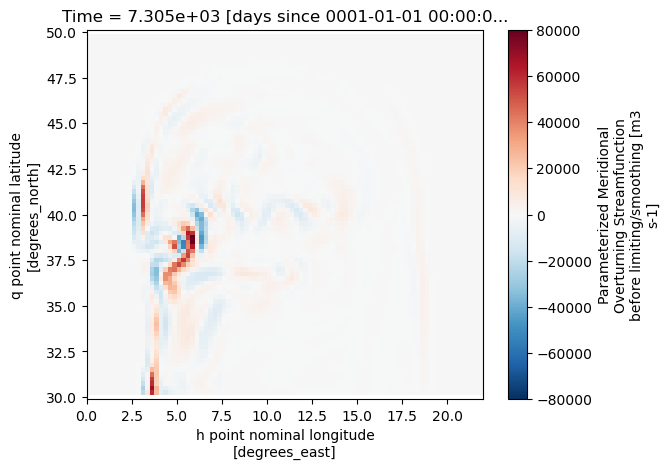

In [338]:
pg23.GM_sfn_unlim_y.isel(zi=1).plot()

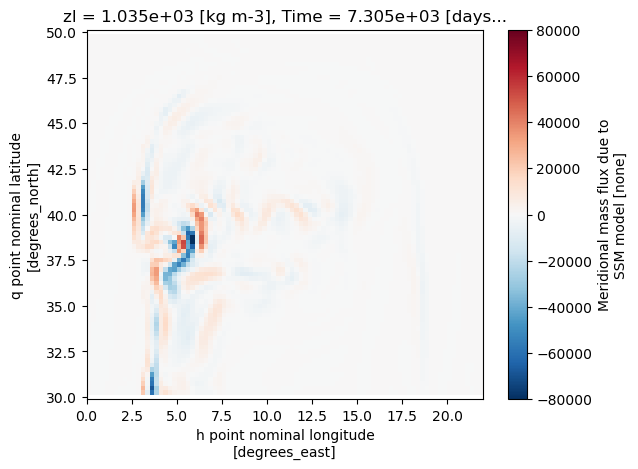

In [339]:
pg23.vhSSM.isel(zl=0).plot()

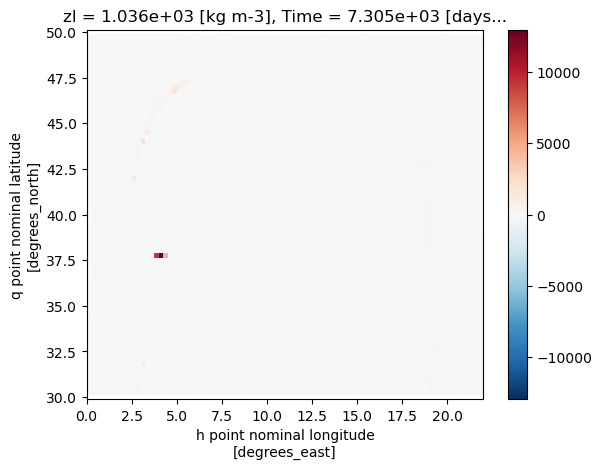

In [340]:
(pg23.vhSSM.isel(zl=1) - pg23.GM_sfn_unlim_y.isel(zi=1)).plot()

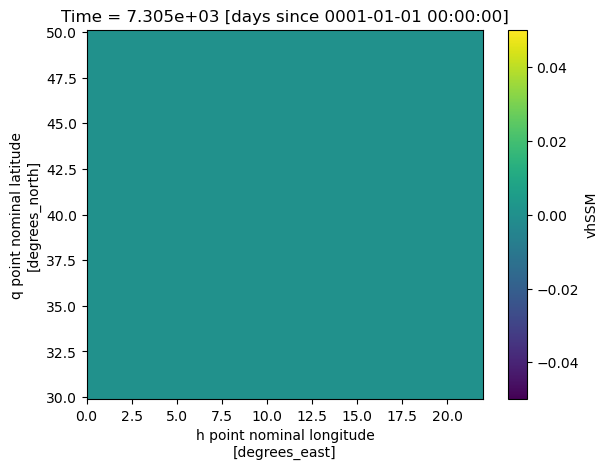

In [337]:
pg23.vhSSM.sum('zl').plot()

In [342]:
import xgcm
grid = xgcm.Grid(static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}},
            boundary={'X': 'fill', 'Y': 'fill'},
            fill_value = {'X': 0, 'Y': 0})
static['wet_u']=np.floor(grid.interp(static.wet,'X'))
static['wet_v']=np.floor(grid.interp(static.wet,'Y'))
static['wet_c']=np.floor(grid.interp(static.wet,['X','Y']))

In [347]:
u, v, h = pg23.SSM_u.fillna(0.), pg23.SSM_v.fillna(0.), pg23.SSM_h.fillna(0.)

uf = filter_iteration(u, static.wet_u, 'xq', 'yh')
vf = filter_iteration(v, static.wet_v, 'xh', 'yq')
hf = filter_iteration(h, static.wet, 'xh', 'yh')

In [368]:
uhD = u * grid.interp(h, 'X')
vhD = v * grid.interp(h, 'Y')
uhD = filter_iteration(uhD, static.wet_u, 'xq', 'yh')
vhD = filter_iteration(vhD, static.wet_v, 'xh', 'yq')
uhD = uhD - uf * grid.interp(hf, 'X')
vhD = vhD - vf * grid.interp(hf, 'Y')
uhD = uhD * static.wet_u * static.dyCu
vhD = vhD * static.wet_v * static.dxCv

In [369]:
hu = grid.interp(h,'X')
uhD = (hu.isel(zl=1) * uhD.isel(zl=0) - hu.isel(zl=0) * uhD.isel(zl=1)) / hu.sum('zl')

In [370]:
hv = grid.interp(h,'Y')
vhD = (hv.isel(zl=1) * vhD.isel(zl=0) - hv.isel(zl=0) * vhD.isel(zl=1)) / hv.sum('zl')

Text(0.5, 1.0, '')

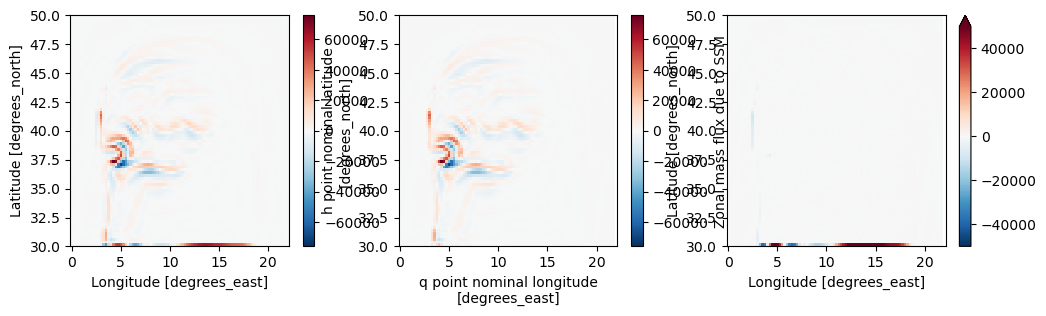

In [371]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
(uhD).plot()
plt.title('')
plt.subplot(1,3,2)
((pg23.uhSSM)).isel(zl=0).plot()
plt.title('')
plt.subplot(1,3,3)
(uhD-pg23.uhSSM.isel(zl=0)).plot(vmax=50000)
plt.title('')

Text(0.5, 1.0, '')

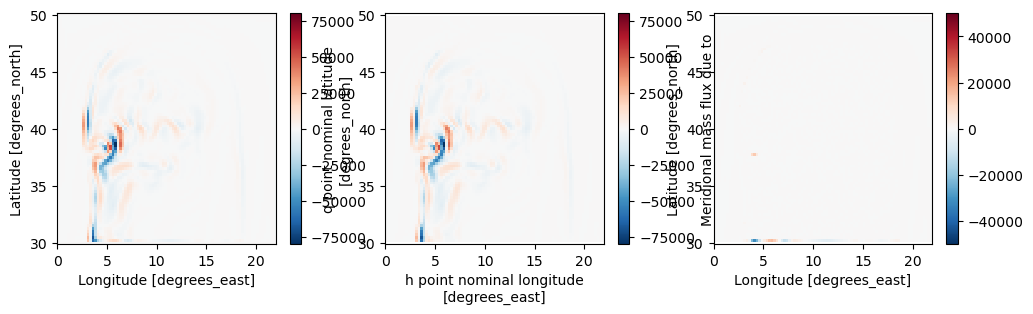

In [372]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
(vhD).plot()
plt.title('')
plt.subplot(1,3,2)
((pg23.vhSSM)).isel(zl=0).plot()
plt.title('')
plt.subplot(1,3,3)
(vhD-pg23.vhSSM.isel(zl=0)).plot(vmax=50000)
plt.title('')

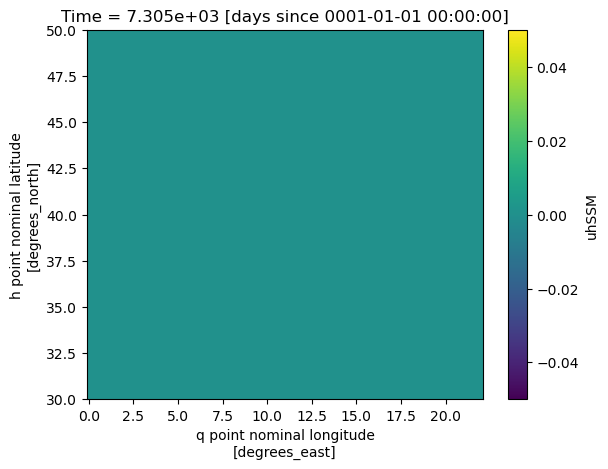

In [373]:
pg23.uhSSM.sum('zl').plot()

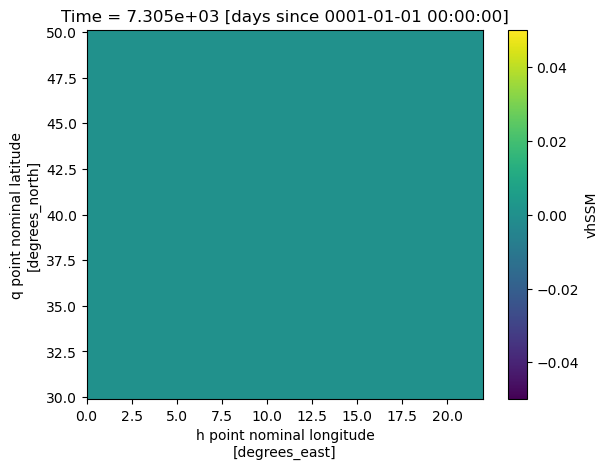

In [374]:
pg23.vhSSM.sum('zl').plot()

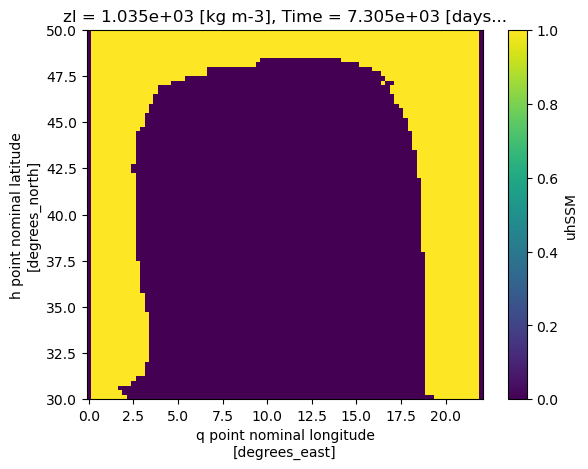

In [375]:
(np.abs(pg23.uhSSM.isel(zl=0))<1e-5).plot()

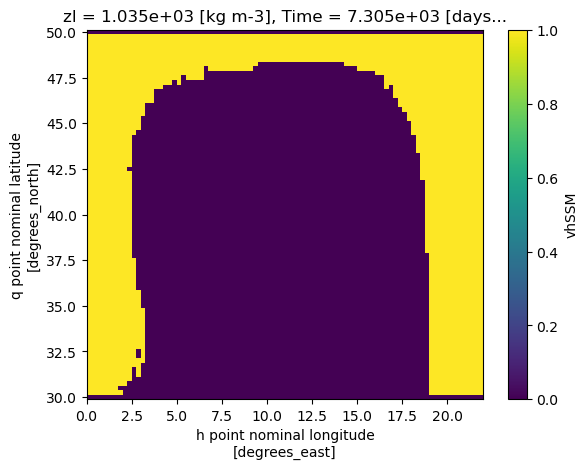

In [378]:
(np.abs(pg23.vhSSM.isel(zl=0))<1e-5).plot()

In [376]:
prog.h.min().compute()

<xarray.DataArray 'h' ()>
array(1.e-10)

In [377]:
# mass was conserved
((pg23.SSM_h - prog.h) * static.dxT * static.dyT).sum(['xh', 'yh']).compute() / ((pg23.SSM_h) * static.dxT * static.dyT).sum(['xh', 'yh']).compute()

<xarray.DataArray (Time: 1, zl: 2)>
array([[-2.95297849e-19, -1.06689906e-18]])
Coordinates:
  * zl       (zl) float64 1.035e+03 1.036e+03
  * Time     (Time) float64 7.305e+03

In [417]:
prog_ctrl = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/Feb2022/bare/R6-0.01/output/prog__0002_026.nc', decode_times=False)
prog = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/SSM-thickness/bare-0.01/R6/output/prog__0002_026.nc', decode_times=False)
cont = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/SSM-thickness/bare-0.01/R6/output/cont__0002_011.nc', decode_times=False)

prog_fun = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/SSM-streamfunction/bare-0.01/R6/prog__0002_026.nc', decode_times=False)
cont_fun = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/SSM-streamfunction/bare-0.01/R6/cont__0002_011.nc', decode_times=False)

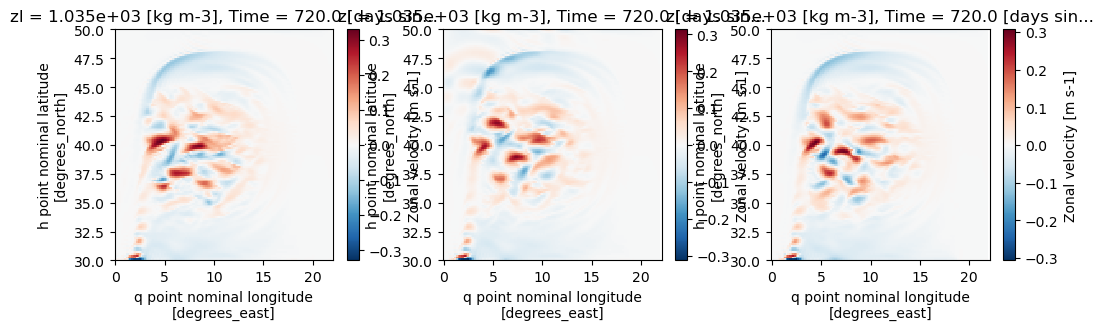

In [434]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
prog_ctrl.u.isel(Time=-1,zl=0).plot()

plt.subplot(1,3,2)
prog.u.isel(Time=-1,zl=0).plot()

plt.subplot(1,3,3)
prog_fun.u.isel(Time=-1,zl=0).plot()

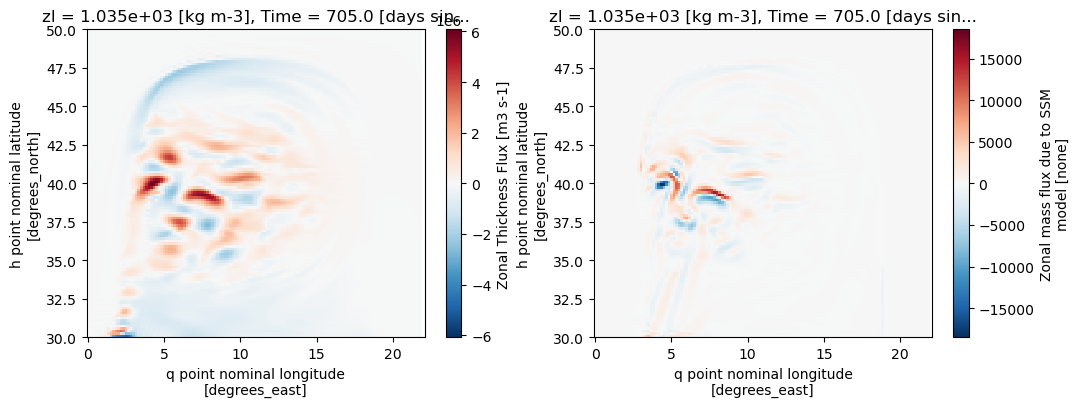

In [429]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cont_fun.uh.isel(zl=0).isel(Time=-1).plot()
plt.subplot(1,2,2)
cont_fun.uhSSM.isel(zl=0).isel(Time=-1).plot()

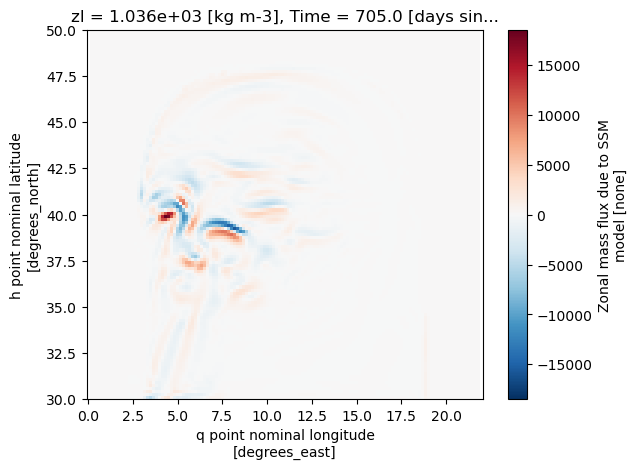

In [433]:
cont_fun.uhSSM.isel(zl=1,Time=-1).plot()